<h1 align="center" style="font-variant: small-caps">How to build a genome-scale self-replicating cell model</h1>
<h2 align="center">TUTORIAL 5 &mdash; Build the final model</h2>
<h5 align="center">(<code>Version 17</code>, September 2025)</h5>

<div align="center" style="max-width:200px;display:block;margin:auto;">

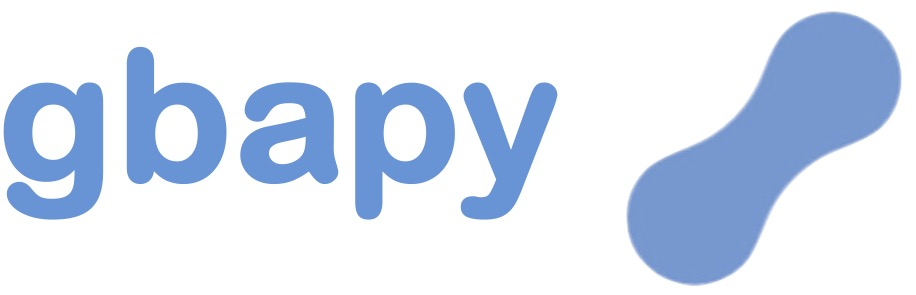

</div>

# Table of contents <a id="table_of_contents"></a>

- [1. Objective](#objective)
- [2. Load the model builder](#load)
- [3. Remove inactive reactions from the SRC model solution](#remove_SRC_inactive)
- [4. Check and adjust mass balance for every reactions](#mass_balance)
- [5. Convert model units](#convert)
  - [5.1. Convert units considering the modeled proteome fraction](#convert_1)
  - [5.2. Set up the ATP maintenance mass $k_\text{cat}$](#convert_2)
- [6. Build the GBA converted model](#build_model)
- [7. Create external conditions](#conditions)
- [8. Add activator metabolites](#activators)
- [9. Enforce the directionality of reactions based on the FBA solution](#direction)
- [10. Export the final model](#export)
- [11. Look for an initial solution](#initial_solution)

# In summary

<div align="center" style="max-width:850px;display:block;margin:auto;">

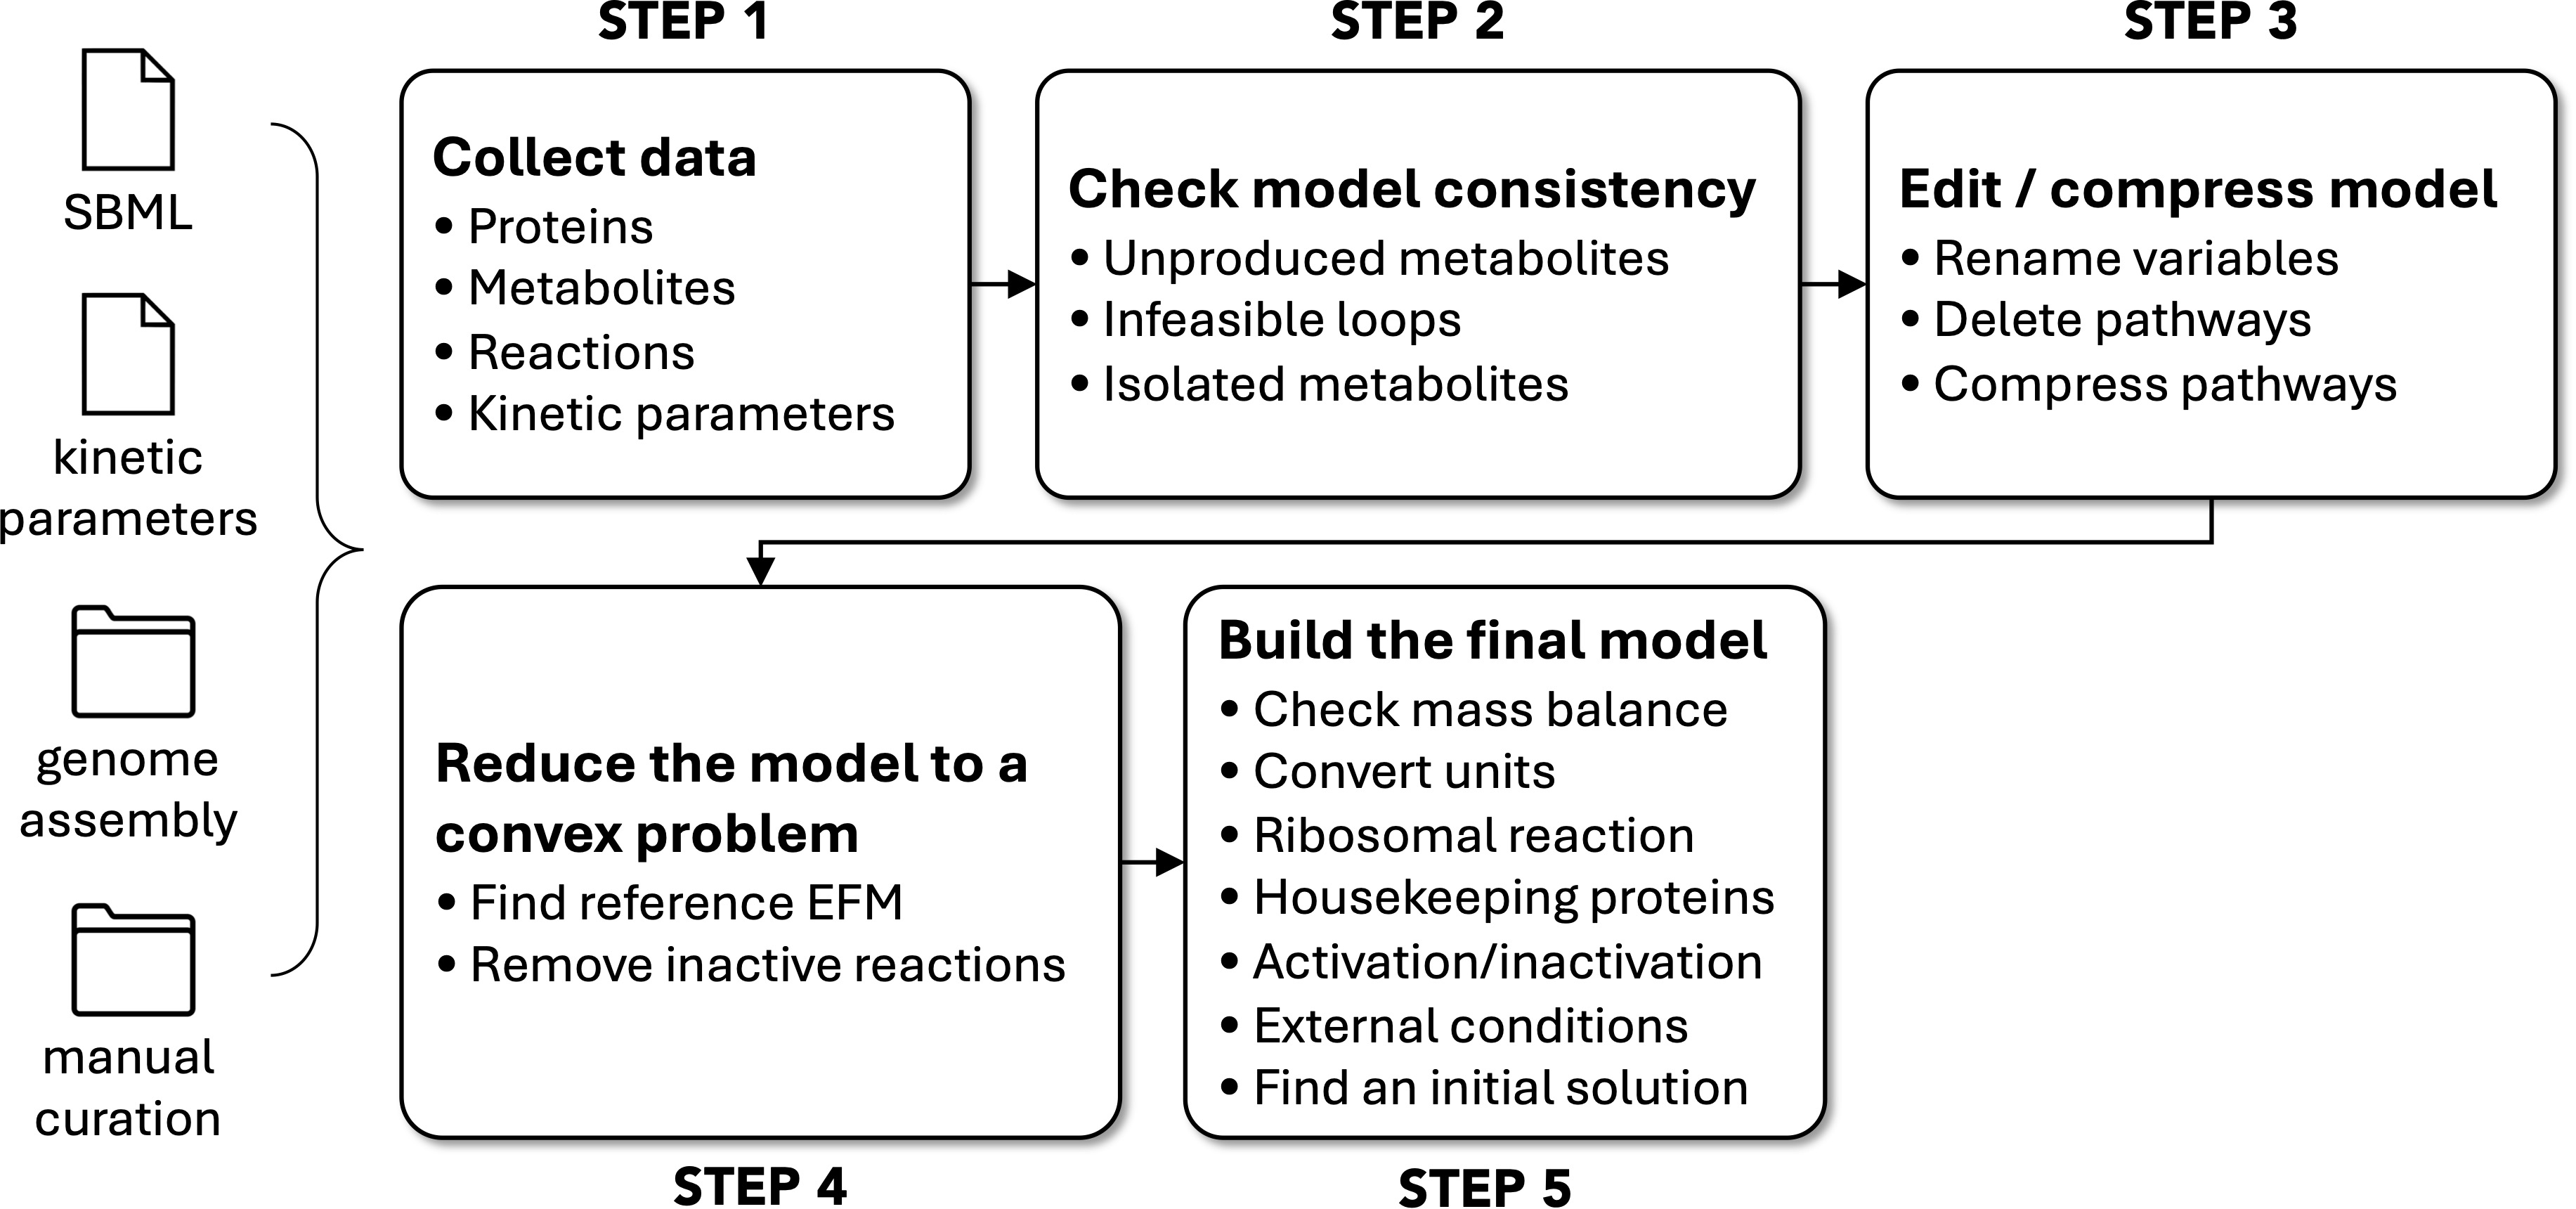

</div>

<div align="center">
<strong>At the beginning of each step of the tutorial, the GBApy methods used are listed</strong>.
</div>

# 1. Objective <a id="objective"></a>

[&#10148; Back to the table of contents](#table_of_contents)

In tutorial 4, we performed a model reduction based on an FBA optimal solution to be as close as possible from a full-column rank model, with a unique optimal solution.

In this tutorial, we will convert it to a self-replicating cell (SRC) model. <strong>gbapy</strong> provides automated methods for this task. The conversion steps are fully described in [Dourado et al. (2023)](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1011156).
See also [section 4](#convert). We will also produce an initial solution to the model.

Due to minor mass conservation discrepancies between FBA and GBA versions, it will be necessary to run a first optimization, and remove remaining dependencies to reach a convex model, where all reactions are active at optimum.

# 2. Load the model builder <a id="load"></a>

[&#10148; Back to the table of contents](#table_of_contents)

<div align="center">

| gbapy method | Description |
| ------ | ----------- |
| <code>gba.load_builder( path )</code> | Load a model builder from a backup |

</div>

The model builder is loaded from the backup created in tutorial 4.
We also re-load the original SBML model of a minimal cell.

In [1]:
import gba
import cobra
import numpy as np

builder    = gba.load_builder("backup/mmsyn_build_4.gbabuild")
sbml_model = cobra.io.read_sbml_model("data/manual_curation/MMSYN_annotated.xml")

Set parameter Username
Academic license - for non-commercial use only - expires 2026-03-15
Read LP format model from file /var/folders/5h/n0xqh1xj2zg6yyd747k95bc80000gn/T/tmpu40c4etr.lp
Reading time = 0.00 seconds
: 138 rows, 286 columns, 1216 nonzeros


# 3. Remove inactive reactions in the SRC model solution <a id="remove_SRC_inactive"></a>

[&#10148; Back to the table of contents](#table_of_contents)

<div align="center">

| gbapy method | Description |
| ------ | ----------- |
| <code>gba.Builder.remove_reactions( reactions )</code> | Remove a list of reactions from the model builder |
| <code>gba.Builder.remove_metabolites( metabolites )</code> | Remove a list of metabolites from the model builder |
| <code>gba.backup_builder( builder, name, path )</code> | Backup a model builder |

</div>

To ensure that a full column rank solution is reached with the model, we have followed the building procedure below on the model produced in tutorial 4, and optimized it using the C++ version of <strong>gbapy</strong> (<strong>gbacpp</strong>, see https://github.com/charlesrocabert/gbacpp). This code has been specifically written to look for optimal solutions in genome-scale models. With this package, we can reach an optimum in a few minutes on a laptop.

At the optimum, 3 reactions are inactive, and are removed below. We then save the builder before proceeding further.

In [2]:
reactions   = ["GHMT2", "FMNAT", "RNA_degrad"]
metabolites = ["fad"]
builder.remove_reactions(reactions)
builder.remove_metabolites(metabolites)
gba.backup_builder(builder, "mmsyn_build_5", "./backup")

# 4. Check and adjust mass balance for every reactions <a id="mass_balance"></a>

[&#10148; Back to the table of contents](#table_of_contents)

<div align="center">

| gbapy method | Description |
| ------ | ----------- |
| <code>gba.Builder.adjust_masses( metabolites )</code> | Adjust masses from a list of positive or negative corrections |
| <code>gba.Builder.check_mass_balance( verbose )</code> | Check the mass balance of each reaction of the model |

</div>

First, we need to check the mass balance of each reaction, <em>i.e.</em> if the total mass of the reactants equals the total mass of the products. By default, <strong>gbapy</strong> uses a threshold of <strong>0.1 Da</strong>, which represents one tenth of a proton mass.

In [3]:
builder.check_mass_balance(verbose=True)

⚠ Warning,"No mass balance for reaction 5FTHFPGS (diff = 292.2431019999999Da, threshold = 0.1Da)."


⚠ Warning,"No mass balance for reaction ACPPAT (diff = 423.10687400000097Da, threshold = 0.1Da)."


⚠ Warning,"No mass balance for reaction ACP_transl (diff = -2325.4832864000928Da, threshold = 0.1Da)."


⚠ Warning,"No mass balance for reaction AGPAT (diff = -423.089551002Da, threshold = 0.1Da)."


⚠ Warning,"No mass balance for reaction DAGGALT (diff = 13.324124999999867Da, threshold = 0.1Da)."


⚠ Warning,"No mass balance for reaction DAGPST (diff = -7.5569999999988795Da, threshold = 0.1Da)."


⚠ Warning,"No mass balance for reaction DASYN (diff = -0.13765799800012246Da, threshold = 0.1Da)."


⚠ Warning,"No mass balance for reaction FMETTRS (diff = 542.6438765499952Da, threshold = 0.1Da)."


⚠ Warning,"No mass balance for reaction GHMT (diff = 30.026026999999885Da, threshold = 0.1Da)."


⚠ Warning,"No mass balance for reaction LIPTA (diff = -10.295351549997577Da, threshold = 0.1Da)."


⚠ Warning,"No mass balance for reaction NADS (diff = 0.31494099599990477Da, threshold = 0.1Da)."


⚠ Warning,"No mass balance for reaction NNATr (diff = -0.31494099600001846Da, threshold = 0.1Da)."


⚠ Warning,"No mass balance for reaction PdhC_transl (diff = -13513.461475998163Da, threshold = 0.1Da)."


⚠ Warning,"No mass balance for reaction dUTPase_transl (diff = -3173.309166699648Da, threshold = 0.1Da)."


⚠ Warning,"No mass balance for reaction tRNAP (diff = 94.58300315200177Da, threshold = 0.1Da)."


⚠ Warning,"No mass balance for reaction AATRS (diff = 17.007345999998506Da, threshold = 0.1Da)."


⚠ Warning,"No mass balance for reaction Ribosome (diff = -9505.605905251577Da, threshold = 0.1Da)."


We must correct the molecular mass of a few metabolites to reach a mass balance:

In [4]:
mass_adjustement = {}

# Amino-acid and tRNA metabolism
mass_adjustement["x_AA"]   = 17.007345999998506
mass_adjustement["AA"]     = 17.007345999998506
mass_adjustement["tRNA"]   = -94.58300315200177
mass_adjustement["AAtRNA"] = -94.58300315200177

# Macro-molecules
mass_adjustement["apoACP"]       = 1752.813
mass_adjustement["ACP"]          = 1752.813
mass_adjustement["ACP_R"]        = 1329.707
mass_adjustement["dUTPase"]      = 2600.639
mass_adjustement["PdhC"]         = 12940.79
mass_adjustement["lpl_PdhC"]     = 12934.08
mass_adjustement["acdhlpl_PdhC"] = 12934.08
mass_adjustement["dhlpl_PdhC"]   = 12934.08
mass_adjustement["Protein"]      = 8932.936

# Other molecules
mass_adjustement["x_5fthf"]     = 292.2431019999999
mass_adjustement["5fthf"]       = 292.2431019999999
mass_adjustement["lgltn"]       = 7.5569999999988795
mass_adjustement["cdpdag"]      = 0.13765799800012246
mass_adjustement["dnad"]        = 0.31494099599990477
mass_adjustement["thfglu3"]     = 30.026026999999885
mass_adjustement["fmettrna"]    = -667.2529067019968
mass_adjustement["galfur12dgr"] = -13.324124999999867

builder.adjust_masses(mass_adjustement)
builder.check_mass_balance(verbose=True)

❯ Info,Model build JCVI-syn3A is mass balanced.


The model is now mass-balanced (with a threshold of 0.1 Da).

# 5. Convert model units <a id="convert"></a>

[&#10148; Back to the table of contents](#table_of_contents)

## 5.1. Convert units considering the modeled proteome fraction <a id="convert_1"></a>

[&#10148; Back to the table of contents](#table_of_contents)

<div align="center">

| gbapy method | Description |
| ------ | ----------- |
| <code>gba.Builder.convert( ribosome_byproducts, ribosome_mass_kcat, ribosome_mass_km )</code> | Convert all model units to GBA units |

</div>

<strong>gbapy</strong> provides automatized methods to convert a model into mass units (this implies the conversion of stoichiometric coefficients and kinetic parameters; see [Dourado et al. 2023](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1011156) for a description).

- <strong>(i)</strong> The stoichiometry of each reaction is converted. For each metabolite $i$ and reaction $j$:
  - Each stoichiometric coefficient is multiplied by the mass of the metabolite $m_i$,
    $$S_{i,j} = S_{i,\cdot} \times m_i$$
  - The calculated mass stoichiometry is then normalized (the sum of reactant coefficients is equal to -1, the sum of product coefficients is equal to 1),
    $$
    M_{i,j} =
    \left\{
    \begin{array}{rl}
    \dfrac{S_{i,j}}{\sum_{i \in \text{reactants}} \lvert S_{i,j} \rvert} & \text{ if $i$ reactant}\\\\
    \dfrac{S_{i,j}}{\sum_{i \in \text{products}} S_{i,j}} & \text{ if $i$ product}
    \end{array}
    \right.
    $$
  - <strong>gbapy</strong> checks calculations at each step.

- <strong>(ii)</strong> $K_\text{M}$ values are converted to mass units:
  - Each $K_\text{M}$ value is multiplied by the mass of the metabolite
    $$K_\text{M,i} = K_\text{M,i} \times m_i \text{ for each metabolite }i$$

- <strong>(iii)</strong> $k_\text{cat}$ values are converted to mass units:
  - Each $k_\text{cat}$ value is multipled by the sum of the product masses times their stoichiometric coefficient, and divided by the mass of the enzyme $e$. Therefore for the forward $k_\text{cat,j}^f$ of reaction $j$:
    $$k_\text{cat,j}^f = k_\text{cat,j}^f \times \dfrac{\sum_{i \in \text{products}} S_{ij} \times m_i}{e_j}$$
  - And for the backward $k_\text{cat,j}^b$:
    $$k_\text{cat,j}^b = k_\text{cat,j}^b \times \dfrac{\sum_{i \in \text{reactants}} S_{ij} \times m_i}{e_j}$$

- <strong>(iv)</strong> We also need to parametrize the mass $k_\text{cat}$ of the ribosomal reaction `Ribosome`. Here, after running some tests, we will set up this value to $16\ h^{-1}$.

In [5]:
builder.convert(ribosome_mass_kcat=16.0, ribosome_mass_km=None)

## 5.2. Set up the ATP maintenance mass $k_\text{cat}$ <a id="convert_2"></a>

Due to the reduced size of the model, a fraction of the proteins are not produced. To compensate for this missing mass, one common strategy it to use the enzyme fraction involved in ATP maintenance (`ATPase`) as the missing "house-keeping" fraction.

We assume that the missing protein fraction is about 50% of total protein amount in the cell. We then have to set up manually the mass $k_\text{cat}$ of the reaction. After running some tests, we found that $k_\text{cat} = 1.11$ was leading to the wanted protein fraction.

In [6]:
builder.reactions["ATPase"].GBA_kcat[gba.ReactionDirection.BACKWARD] = 1.11

# 6. Build the GBA converted model <a id="build_model"></a>

[&#10148; Back to the table of contents](#table_of_contents)

<div align="center">

| gbapy method | Description |
| ------ | ----------- |
| <code>gba.Builder.build_GBA_model()</code> | Build the GBA converted model |

</div>

A GBA converted model is a set of matrices and vectors:
- The mass fraction matrix $M$, which is the pendant in normalized mass units of the stoichiometric matrix,
- The forward and backward $k_\text{cat}$ vectors,
- The forward and backward $K_\text{M}$ matrices,
- The activation matrix $K_\text{A}$,
- The inhibition matrix $K_\text{I}$,
- The regulation matrix $K_\text{R}$.

All these objects are created through the method `builder.build_GBA_model()`.

In [7]:
builder.build_GBA_model()

# 7. Create external conditions <a id="conditions"></a>

[&#10148; Back to the table of contents](#table_of_contents)

<div align="center">

| gbapy method | Description |
| ------ | ----------- |
| <code>gba.Builder.clear_conditions()</code> | Delete all the external conditions of the model |
| <code>gba.Builder.add_condition( condition_id, rho, default_concentration, metabolites )</code> | Add an external condition to the model |

</div>

To run a model, it is necessary to define the external conditions, that is, the concentration of external metabolites. We also need to define the total density of the cell $\rho$.

#### • Total density :

Minimal cells contains around 72% of water. Water molecules are involved in JCVI-syn3A metabolic reactions, but it is generally assumed that they represent only a small fraction (< 1%) of the total amount of water in the cell. We will then reduce the problem to the dry mass density, which is around 340 g/L ($\rho = 340$) in <em>E. coli</em>. We then add 1% of water mass, leading to $\rho \approx 349$.

#### • External concentrations :

We will use two references to define the medium:
- [Breuer et al. (2019)](https://elifesciences.org/articles/36842)
- [Thornburg et al. (2022)](https://www.sciencedirect.com/science/article/pii/S0092867421014884#app2)

As stated in [Breuer et al. (2019)](https://elifesciences.org/articles/36842), we will assume that all concentrations are saturating, except for glucose, which is the only sugar source in the medium, we will therefore use a concentration of 1 g/L by default.
- In the SP4 medium, 5 g/L of glucose are added. However, the CMRL 1066 broth also contains glucose, leading to an additional amount of 0.4 g/L of glucose.
- As water is included in our model, we will assume a constration of 1,000 g/L for water,
- We will also assume a pH of 7, that is, a concentration of $10^{-7}$ g/L of protons.

Then, [Thornburg et al. (2022)](https://www.sciencedirect.com/science/article/pii/S0092867421014884#app2) defined external concentrations to run dynamical simulations (see `./tutorials/MMSYN_tutorial/data/Thornburg-et-al-2022/simulation_medium.csv`). It will be necessary to convert concentrations units (mM) into mass units (g/L).

Every other external metabolites will be set up to the saturating concentration of 1 g/L.

#### • Generation of an external glucose gradient :

For our modeling approach, we will create a range of glucose concentration between 0 and 10 g/L (plus the CMRL 1066 glucose), to mimick a real experimental protocol.

In [8]:
# (1) Load the medium composition from Thrornburg et al. (2022)
f           = open("./data/Thornburg-et-al-2022/simulation_medium.csv", "r")
l           = f.readline()
l           = f.readline()
metabolites = {}
while l:
    l    = l.strip("\n").split(";")
    m_id = l[1]
    conc = float(l[4])
    if m_id in builder.metabolites:
        metabolites[m_id] = conc*0.001*builder.metabolites[m_id].mass
    l = f.readline()
f.close()

# (2) Complete the medium composition
metabolites["x_h2o"] = 1000.0
metabolites["x_h"]   = 1e-7

# (3) Create external conditions with an external glucose gradient
glucose_gradient = 10.0**np.arange(-5.9, 1.1, 0.1)
index            = 1
builder.clear_conditions()
for i in range(len(glucose_gradient)):
    metabolites["x_glc__D"] = glucose_gradient[i]
    builder.add_condition(condition_id=index, rho=349.0, default_concentration=1.0, metabolites=metabolites)
    index += 1

# 8. Add activator metabolites <a id="activators"></a>

[&#10148; Back to the table of contents](#table_of_contents)

<div align="center">

| gbapy method | Description |
| ------ | ----------- |
| <code>gba.Builder.add_activation_constant( metabolite_id, reaction_id, value )</code> | Add an activator metabolite to a reaction |
| <code>gba.Builder.add_constant_rhs( metabolite_id, value )</code> | Add a constant RHS term for the initial solution |

</div>

To make the model more realistic, we will design specific metabolites as activators of important reactions in the model:
- DNA is an activator of its own production, as well as an activator of the transcription of RNA molecules (<em>i.e.</em> RNAs and tRNAs).
- RNA is an activator of the translation of proteins through the ribosomal reaction `Ribosome`.

According to [Breuer et al. (2019)](https://elifesciences.org/articles/36842), the mass fractions of these metabolites are:
- DNA: 5.5% of dry mass,
- RNA: 16.274% of dry mass.

As the total density of the cell is $\rho = 349$ g/L, the expected mass concentration of DNA and RNA in the cell are:
- DNA = $\rho \times 0.055 = 19.195$ g/L,
- RNA = $\rho \times 0.16274 = 56.79626$ g/L.

We can therefore set the $K_\text{A}$ constants with these mass concentrations, as an approximation:

In [9]:
rho = 349.0
DNA = 5.5/100.0
RNA = 16.274/100.0

# DNA is a self-activator
builder.add_activation_constant("DNA", "DNAP", DNA*rho)

# DNA activates the transcription of RNA
builder.add_activation_constant("DNA", "RNAP", DNA*rho)

# DNA activates the transcription of tRNA
builder.add_activation_constant("DNA", "tRNAP", DNA*rho)

# RNA activates the translation of proteins
builder.add_activation_constant("RNA", "Ribosome", RNA*rho)

We also set the RHS terms of DNA and RNA as constant based on their proportions, in order to enforce an initial solutions with these values.

The RHS term is equivalent to the normalized metabolite concentrations $b$, which sums up to 1. The value to provide are therefore:

In [10]:
builder.add_constant_rhs("DNA", DNA)
builder.add_constant_rhs("RNA", RNA)

# 9. Enforce the directionality of reactions based on the FBA solution <a id="direction"></a>

[&#10148; Back to the table of contents](#table_of_contents)

<div align="center">

| gbapy method | Description |
| ------ | ----------- |
| <code>gba.Builder.enforce_directionality( flux_vector )</code> | Enforce the directionality of the model given a flux vector |

</div>

To help numerical solvers, it is usually better to optimize strickly positive values. We will then force all reactions to be forward irreversible. A majority of JCVI-syn3A reactions are forward irreversible (<strong>73.58%</strong>), only one is backward irreversible, and <strong>25.94%</strong> of reactions are reversible. We will then use the original FBA solution to enforce the direction of all reactions.

In [11]:
builder.enforce_directionality(builder.FBA_solution.fluxes)

# 10. Export the final model <a id="export"></a>

[&#10148; Back to the table of contents](#table_of_contents)

<div align="center">

| gbapy method | Description |
| ------ | ----------- |
| <code>gba.Builder.export_model( path )</code> | Export the model in CSV format |

</div>

We will now export the model in the standard format of a set of CSV files.

In [12]:
builder.write_to_csv("./models", name="mmsyn_v1")

# 11. Look for an initial solution <a id="initial_solution"></a>

[&#10148; Back to the table of contents](#table_of_contents)

<div align="center">

| gbapy method | Description |
| ------ | ----------- |
| <code>gba.read_csv_model( name, path )</code> | Load a model (class Model) from CSV files |
| <code>gba.Model.generate_LP_initial_solution( max_flux_fraction, rhs_factor, save_f0) </code> | Generate and test an initial solution to the model using a LP routine |

</div>

To test for an initial solution, we will load the freshly created model as a `Model` object.
This class is optimized for GBA algorithms, and is separated from the model builder (class `Builder`) for practical reasons.

First, we load the model from the CSV files:

In [13]:
model = gba.read_csv_model(name="mmsyn_v1", path="./models")

Then, we look for an initial solution. This is done in two steps:
- 1) A linear routine is calculated to generate an initial flux fraction vector `GbaModel.LP_solution`,
- 2) The state of the model is calculated from this solution,
- 3) The consistency of the model is checked (mainly, positivity of main variables and a total density of 1). If the model is consistent we save the initial solution.

#### Notes
- The parameter `max_flux_fraction` indicates the maximal flux value to the LP program to find the initial solution (here `max_flux_fraction = 40.0`),
- The RHS factor (`rhs_factor`) is a weighting factor used to adjust the right-hand side of the linear problem. One can adjust its value to find a solution (usually, a smaller RHS factor increases the chance to find a consistent solution). Here, we choose `rhs_factor = 10` after testing different values by hand.

In [36]:
model.find_initial_solution(condition_id="67", max_flux_fraction=40.0, rhs_factor=1040.0)

❯ Info,Model is consistent with mu = 0.17685637651337882.


In [15]:
model.write_to_csv("./models", name="mmsyn_v1")
model.write_to_ods("./models", name="mmsyn_v1")